### Mean reversion detection (an essential draft of the progress)

This notebook contains a brief summary of what has already been done as of now. Functions calls are imported via an independent Python module `meanreversion.py`. We won't delve deep into the implementation of such functions

#### Operative definition of mean reversion process
__Mean reversion__ is defined as the tendency of a dataset to return to its historical average. We need a way to comprehend whether a process is mean reverting or not. As we intended it, we can build a conceptual scheme:

<img src="images/MR.png"  width="750"/>



#### Stationarity

If the time series is stationary, we can further distinguish between two different scenario:

<img src="images/high_mr.png"  width="650"/>
<img src="images/low_mr.png"  width="650"/>

In the upper figure, one could say that the dataset actually never leaves the historical average ($=0$) but merely fluctuates around it (statistical random fluctuations of the market). So it is stationary and it is dominated by small fluctuations that can be interpreted as low-period stochastic noise

On the contrary, the dataset below displays an evident and statistically significative departure from the global average. It then returns at the average and keeps on oscillating around it. This is still stationary but has an oscillatory trend that is not simply due to the noise


## Step 1: Collecting data

We start by collecting and formatting the relevant data

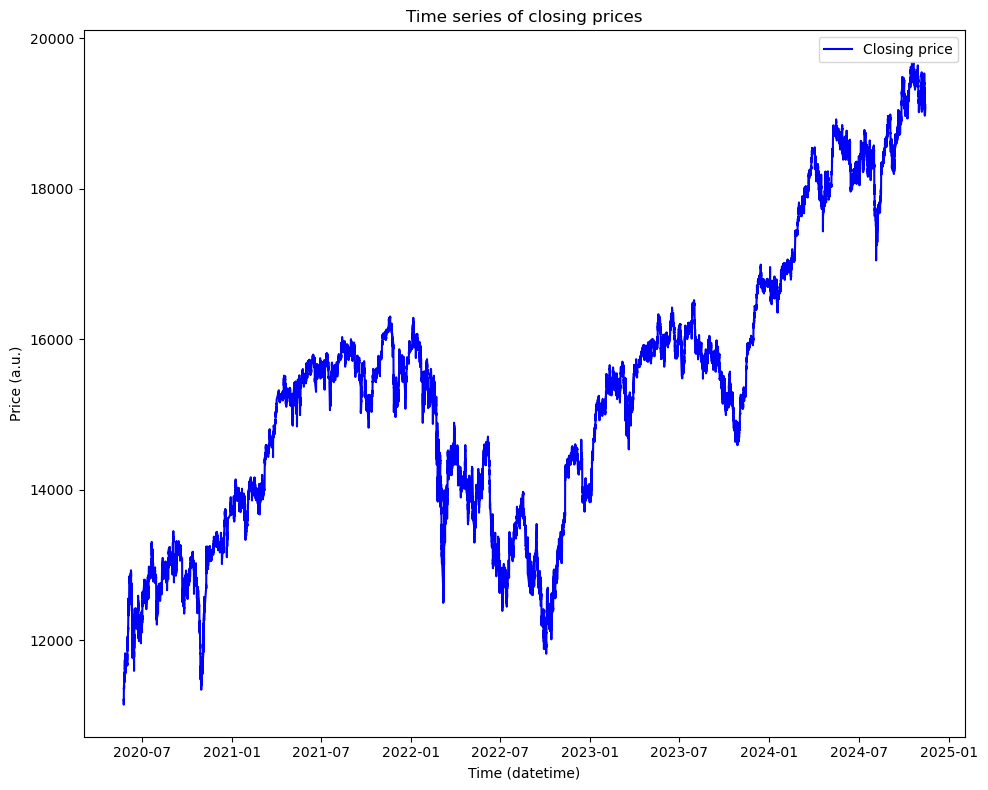

In [2]:
import meanreversion as mr

DAX = mr.load_asset("data/DAX_M15_202005242300_202411131015.csv")
# if we wanted to plot them, then
mr.draw_info(DAX)

Sometimes we want to _measure_ the mean-reverting tendency of just a small portion of an entire dataset. Consequently, we split the loaded dataset into chunks and remove the linear trend from each segment

N.B. This is formally what Group 2 should focus on (removing the trend), but since mean reversion can also occur while oscillating around trends, we believe it's better to at least remove a linear trend. Furthermore, it's difficult for a dataset to have a constant historical average of exactly $0$ (as shown in the initial defining figure)
Also, note that our approach to this linear fit detection is extremely naive and simple (a couple of lines of code): we visually identify the trends and simply perform linear fits. This is as far as we will go concering the detection of trends

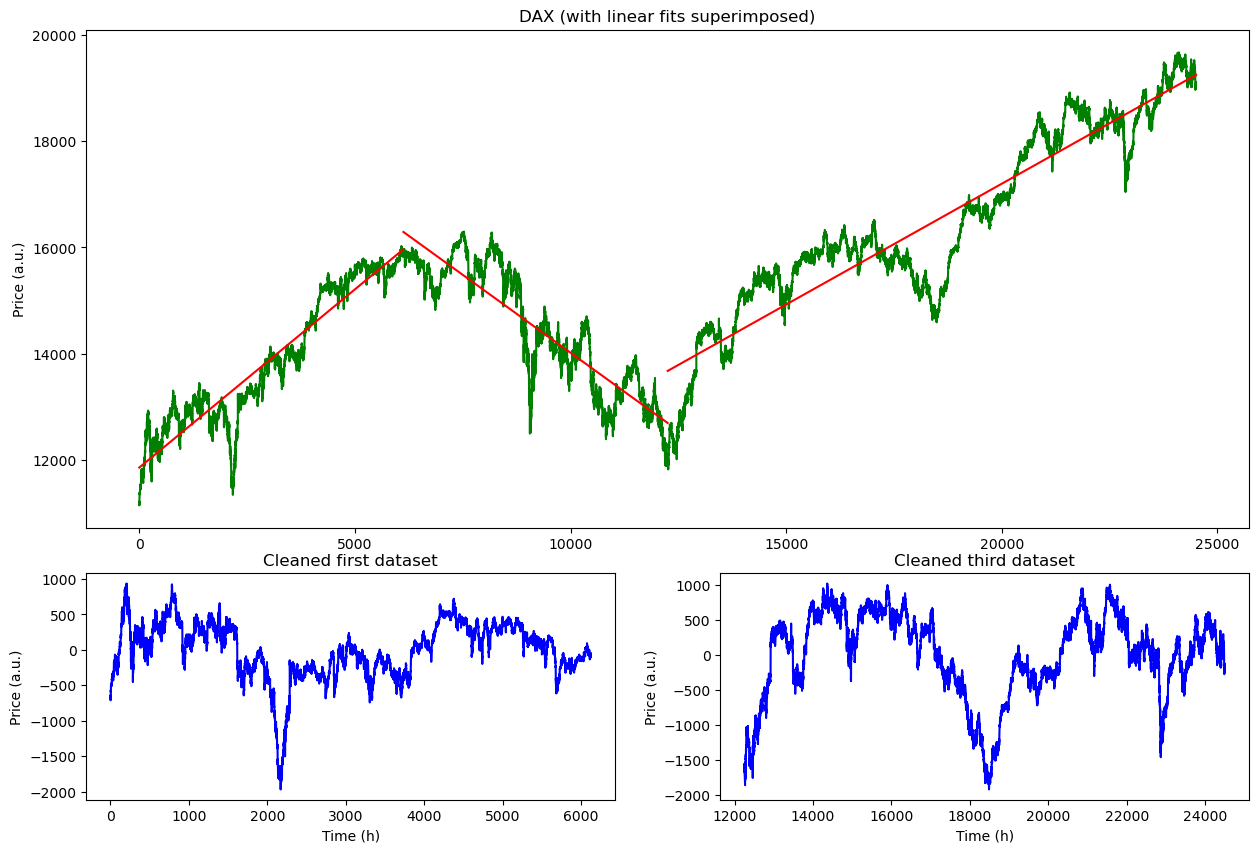

In [3]:
import numpy as np
import matplotlib.pyplot as plt

df, name = DAX, "DAX"
gridsize = (3,2)
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
ax1.plot(df.index, df["Close"], c = "g")
ax1.set_title(name + " (with linear fits superimposed)")
ax1.set_ylabel("Price (a.u.)")

# and perform the removal of the trend. Passing ax as an optional argument, we can superimpose the linear fits to visually see the fitting line
mesh = np.array([0,int(len(df)/4), int(len(df)/2), int(len(df))])
arr = mr.removeTrend(df, mesh, ax1)

ax2 = plt.subplot2grid(gridsize, (2,0), colspan=1, rowspan=1)
ax2.plot(arr[0].index, arr[0].values, c = "b")
ax2.set_title("Cleaned first dataset")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Price (a.u.)")

ax3 = plt.subplot2grid(gridsize, (2,1), colspan=1, rowspan=1)
ax3.plot(arr[2].index, arr[2].values, c = "b")
ax3.set_title("Cleaned third dataset")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("Price (a.u.)")

plt.tight_layout
plt.show()

We have now a bunch of small datasets (variable `arr`) for every asset that have null historical average. We can now go ahead and measure the mean-reversion tendency for each of those segments

## First algorithm
We start by regularizing the dataset using a filter. We should get a smooth function that is hopefully oscillating around the average (0). We then proceed to find the period of oscillations by counting the intersection with the x-axis (and averaging them out) and the amplitude

If the dataset is low mean-reverting: we expect small amplitude (due to fluctuations, essentially) and high frequency (noise has typical high freq)

If the dataset is highly mean-reverting: higher amplitude, lower frequency

Number of points: 205
Periods:  0.49019607843137253
Amplitudes:  0.1407983960271175


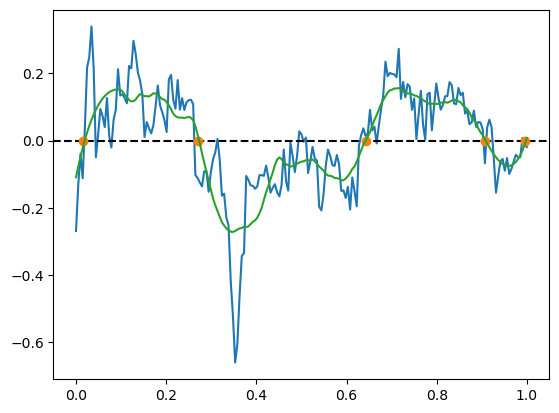

In [119]:
from scipy.signal import savgol_filter

# Selecting a subsample of points (computational cost of the minimization and stability)
# TODO: volatility seems to be sensitive to the number of points, so we should find a way to make it more stable
x = arr[0].to_numpy()[::120]
t = arr[0].index.to_numpy()[::120]
print("Number of points:", len(x))
t = (t - t.min()) / (t.max()-t.min()) 
x = x / (x.max()-x.min())  
x_filtered = savgol_filter(x, window_length=len(x)//5, polyorder=3)

periods = mr.find_periods(t, x_filtered)
peaks = mr.find_amplitudes(t, x_filtered)

print("Periods: ", np.mean(periods))
print("Amplitudes: ", np.mean(peaks))

plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.show()

A similar result can be obtained by looking at the Fourier transform of the signal and selecting the highest freq

In [120]:
period_fft, phase_fft = mr.find_period_fft(t, x_filtered)
print("Period via FFT: ", period_fft)
print("Phase via FFT: ", phase_fft)

Period via FFT:  0.5024509803921569
Phase via FFT:  -0.5737677927976373


A common way to model an asset is using a stochastic differential equation $dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$. $\sigma$ represent the volatility of the asset an $f(x,t,\boldsymbol{\theta})=\theta(A\sin(\omega t+\varphi)-x)$ include the drift of the price (for now assumed sinusoid). To find the parameters $\boldsymbol{\theta}=\{\theta,\sigma,...\}$ we use maximum likelihood method.

As mean reversion metric we can choose the ratio between amplitude and volatility: if the amplitude of the oscillation is bigger than the random fluctuation, then we have a mean reversion dynamic: $MRI=A/\sigma$. If $MRI$ (Mean Reversion Index) is significally bigger than one, then is more likely that we have mean reversion.

 

In [121]:
# to simplify the minimization process we assume that the period and amplitude are known from the previous calculation
amplitude = np.mean(peaks)
frequency = 2*np.pi / ((np.mean(periods) + period_fft)/2)
print("Amplitude: ", amplitude)
print("Frequiency: ", frequency)

# Define the SDE
def f(t, x, params):
    omega, phi, theta, _ = params
    A = amplitude
    return theta * (A*np.sin(omega*t + phi) - x) + A*omega*np.cos(omega*t + phi)

def g(x, params):
    return params[3]

from scipy.optimize import minimize
bounds = ((0, None), (-2*np.pi, 2*np.pi), (0.0, None), (0.0, None))  # bounds for the parameters
guess = [frequency, phase_fft, 1.0, 1.0]
print("\nInitial guess: ", guess)

res = minimize(mr.log_likelihood, guess, args=(x_filtered, t, f, g), method='L-BFGS-B', options={'disp': False, 'ftol': 1e-6}, bounds=bounds)
omega_val, phi_val, theta_val, sigma_val = res.get('x')

print("Optimal parameters: ", res.get('x'))
print(f"\nVolatility: {sigma_val:.4}")
print(f"Amplitude-volatility ratio: {amplitude/sigma_val:.4}")
print(f"Ornstein-Uhlenbeckrn half-life {np.log(2)/theta_val:.4}")

Amplitude:  0.1407983960271175
Frequiency:  12.659454841132202

Initial guess:  [12.659454841132202, -0.5737677927976373, 1.0, 1.0]
Optimal parameters:  [12.53241789 -1.48096382  1.06527562  0.15922032]

Volatility: 0.1592
Amplitude-volatility ratio: 0.8843
Ornstein-Uhlenbeckrn half-life 0.6507


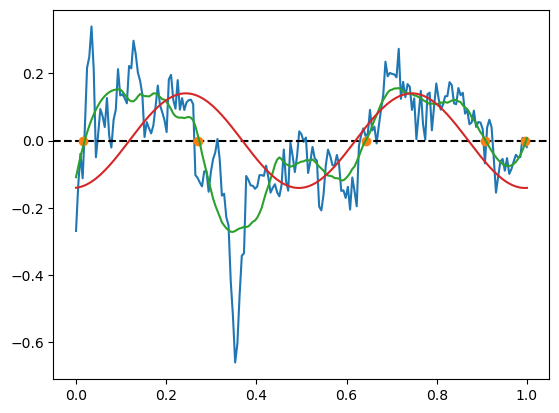

In [122]:
plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val))
plt.show()

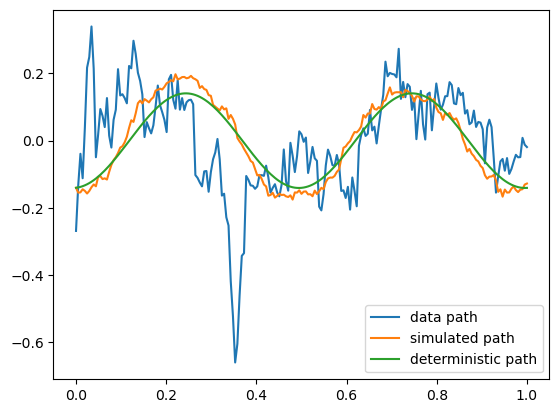

In [127]:
mu = lambda t, x : theta_val * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : sigma_val

X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.legend()
plt.show()

## Second algorithm

The second algorithm is based on statistical assumptions. Let's go back to the first two images, i.e., the one defining a mean-reverting process.

Let's pick a value for $\lambda$ and start sampling points from those datasets, choosing samples that are on average at a distance of $\lambda$ from each other. We can observe how those points are distributed, and we'll obtain something like:


<img src="images/gauss.png" width="600"/> <img src="images/nongauss.png" width="600"/>

In the first case (up, low mean reverting), the process is dominated by statistical fluctuations, which are (hopefully) normally distributed.

In the second case, the process is dominated by an oscillating mean-reverting trend, and the distribution is not Gaussian.

Thus, we can say that the more Gaussian a distribution is, the lower the mean-reverting tendency.

N.B. The data shown above are generated; they do not belong to a real dataset. This is all just to illustrate how things should behave in theory

21.94621923288514 8.403950794708635 39.360848931373766


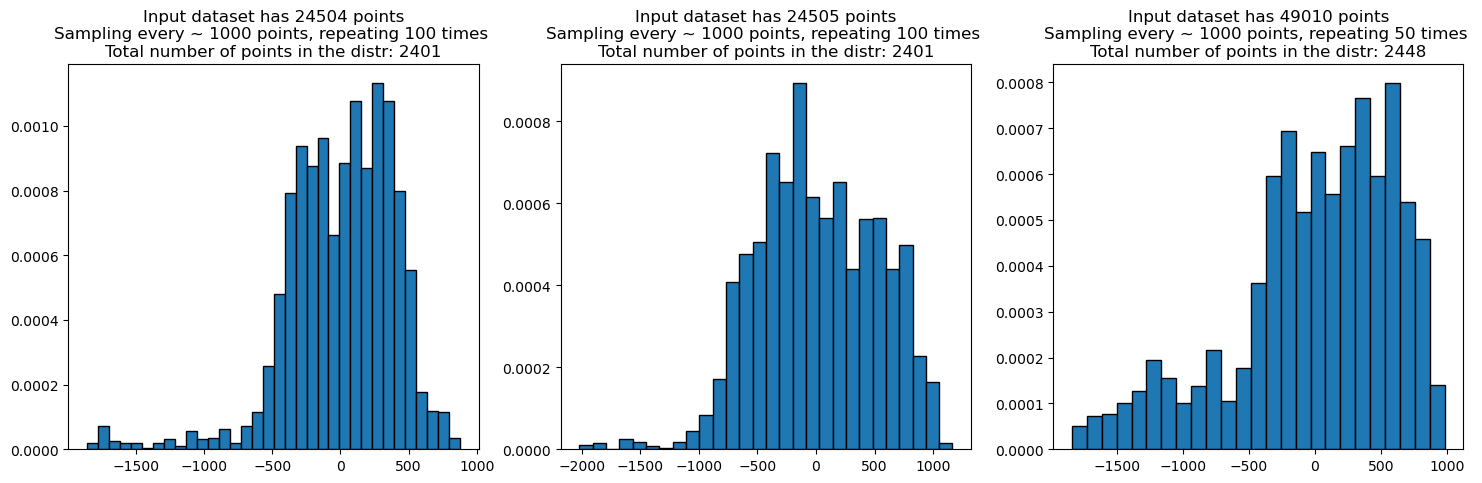

In [ ]:
# This function takes in a dataset and returns the "normality" of the dataset
# We can choose lambda (first parameter) and n, i.e. the number of times we repeat the sampling to average out the results

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
normality1 = mr.assess_normality(arr[0], 1000,100, axs[0])
normality2 = mr.assess_normality(arr[1], 1000,100, axs[1])
normality3 = mr.assess_normality(arr[2], 1000,50, axs[2])
print(normality1, normality2, normality3)